## Import your stuff

In [2]:
import numpy as np
import simulators.jla_supernovae.jla_simulator as jla
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import pydelfi.score as score
import pydelfi.priors as priors
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [2]:
import pylab as plt
import pyccl as ccl
import scipy
from scipy.interpolate import interp1d

import matplotlib
%matplotlib inline

import time
import importlib

print("CCL version you are using:",ccl.__version__)

CCL version you are using: 2.1.0


In [3]:
font_config = {"size" : 10,
               "family" : "serif"}

matplotlib.rc("font", **font_config)
matplotlib.rc("text", usetex=True)
# Move title to make space for exponents of y axis
matplotlib.rc("axes", titlepad=5) 
matplotlib.rc("axes", titlesize="medium") 

# Make the figures bigger in the notebook
matplotlib.rc("figure", dpi=150)

color_map = plt.get_cmap("tab10")

paper_textwidth = 7.125
fig_size = (paper_textwidth/2, 2.6)

plot_adjust = dict(left=0.2, top=0.9, bottom=0.2)

In [4]:
import simulators.mass_function_n_counts.simulator_trapz_m500 as n_counts_simulator
importlib.reload(n_counts_simulator)

<module 'simulators.mass_function_n_counts.simulator_trapz_m500' from '/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_m500.py'>

## Set up priors on params of interest (for now): {$\Omega_{m}h^{2} = \Omega_{cdm}h^{2} + \Omega_{b}h^{2}$, $\sigma_{8}$, $h$, $n_{s}$, $w_{0}$}

In [5]:
lower = np.array([0.1125, 0.020, 0.6])
upper = np.array([0.1275, 0.024, 1.1])
prior = priors.Uniform(lower, upper)

In [3]:
theta_fiducial = np.array([0.1197, 0.02222, 0.76])


## Define mass calibration parameters

In [4]:
mass_calibration_param_names = ['\\alpha_{Y}', '\\beta_{Y}', '\\gamma_{Y}', 'Y_{*}', 'M_{*}', 
                                '\\alpha_{\sigma}', '\\gamma_{\sigma}', '\\sigma_{log Y_{0}}']
theta_fiducial_mass_calibration = np.array([1.8, 0., 0., 2.4e-10, 1e14, 0., 0., 0.127])

In [60]:
log10masses = np.linspace(14, 16, num = 5)
z_min = np.linspace(0.1, 0.9, num = 5)
z_max = np.linspace(0.2, 1.0, num = 5)
log10masses_2d = np.stack((log10masses[:-1], log10masses[1:]))

In [61]:
N_countsSimulator = n_counts_simulator.Model(log10masses, z_min, z_max)

0.603261818 s


In [62]:
N_countsSimulator.N_counts

array([6.93570283e+03, 2.12245611e+04, 2.68131452e+04, 2.27865738e+04,
       1.49412370e+04, 5.42447860e+02, 1.28066151e+03, 1.17583495e+03,
       6.77034429e+02, 2.84660843e+02, 9.09725925e+00, 1.37157108e+01,
       7.16038628e+00, 2.04769383e+00, 3.83229867e-01, 5.72580092e-03,
       3.66691546e-03, 6.34184903e-04, 4.53809242e-05, 1.68220280e-06])

In [6]:
np.concatenate((theta_fiducial, theta_fiducial_mass_calibration))

array([1.197e-01, 2.222e-02, 7.600e-01, 1.800e+00, 0.000e+00, 0.000e+00,
       2.400e-10, 1.000e+14, 0.000e+00, 0.000e+00, 1.270e-01])

## Get Cosmology and HMF 

In [9]:
# Define a mass definition object
hm_def = ccl.halos.MassDef(500, 'critical')
cosmo_ccl = N_countsSimulator.cosmo(theta_fiducial)
nM = ccl.halos.MassFuncTinker08(cosmo_ccl, mass_def=hm_def)

In [10]:
def compute_mass_calibration_params(theta_mass_calibration, M_500, z):
    t1 = time.process_time()
    alpha_Y = theta_mass_calibration[0]
    beta_Y = theta_mass_calibration[1]
    gamma_Y = theta_mass_calibration[2]
    
    Y_star = theta_mass_calibration[3]
    M_star = theta_mass_calibration[4]
    
    alpha_sigma = theta_mass_calibration[5]
    gamma_sigma = theta_mass_calibration[6]
    sigma_logY0 = theta_mass_calibration[7]
    
    scale_fact_a = 1/(1+z)
    #t2 = time.process_time()
    
    E_z = (ccl.background.h_over_h0(cosmo_ccl, scale_fact_a)**(2/3))
    if ccl.background.comoving_radial_distance(cosmo_ccl, scale_fact_a) == 0:
        D_A_z = 0.
    else:
        D_A_z = (ccl.background.comoving_radial_distance(cosmo_ccl, scale_fact_a)/100)**(-2)
   
    mean_Y_500 = Y_star*((M_500/M_star)**alpha_Y)*np.exp(beta_Y*(np.log10(M_500/M_star)**2))*((1+z)**gamma_Y)*E_z*D_A_z
    
    sigma_logY_500 = sigma_logY0*((M_500/M_star)**alpha_sigma)*((1+z)**gamma_sigma)
    
    t2 = time.process_time()
    #print(t2 - t1)
    return mean_Y_500, sigma_logY_500

In [11]:
def compute_probability_Y_500(theta_mass_calibration, Y_500_true, M_500, z):
    t1 = time.process_time()
    
    mean_Y_500, sigma_logY_500 = compute_mass_calibration_params(theta_mass_calibration, M_500, z)
    
    prob_Y_500_true = np.exp(-((np.log10(Y_500_true) - np.log10(mean_Y_500))**2)/(2*(sigma_logY_500**2)))/(np.sqrt(2*np.pi)*sigma_logY_500)
    
    t2 = time.process_time()
    #print(t2 - t1)
    return prob_Y_500_true

In [12]:
mean_Y_500, sigma_logY_500 = compute_mass_calibration_params(theta_fiducial_mass_calibration, 1e15, 0.5)
compute_probability_Y_500(theta_fiducial_mass_calibration, 5e-11, 1e15, 0.5)

3.136997944522371

In [13]:
def Y_500_trapz(theta_mass_calibration, M_500, z, Y_min, Y_max, n_steps_Y = 1000):
    t1 = time.process_time()
    
    Y_steps = np.linspace(Y_min, Y_max, num=n_steps_Y)
    p_Y_true = np.array([compute_probability_Y_500(theta_mass_calibration, Y_500_true, M_500, z)/Y_500_true for Y_500_true in Y_steps])
    #p_Y_true = np.array([compute_probability_Y_500(theta_mass_calibration, Y_500_true, M_500, z) for Y_500_true in Y_steps])
    
    
    integral_trapz = np.trapz(p_Y_true, Y_steps)
    
    t2 = time.process_time()
    #print(t2 - t1)
    return integral_trapz

In [14]:
p_Y_true = Y_500_trapz(theta_fiducial_mass_calibration, 1e15, 0.5, 3e-11, 5e-11, n_steps_Y = 1000)

## Compute number counts with a loop

In [15]:
#z_min = np.array([0., 0.25, 0.5, 0.75, 1.])
#z_max = np.array([0.25, 0.5, 0.75, 1., 1.5])
z_min = np.array([0.])
z_max = np.array([0.25])
n_steps_z = 100
n_bins_z = len(z_min)

In [16]:
Y_bins_limits = [np.logspace(np.log10(8.6e-12), np.log10(3.9e-9), num = 16)]

In [17]:
n_steps_M_500 = 100
log10_M_500_steps = np.linspace(6, 16, num = n_steps_M_500)
M_500_steps = 10**log10_M_500_steps

In [18]:
H0 = 100 * 0.69
c = ccl.physical_constants.CLIGHT * 1e-3  # in km/s
counts = []
for n in range(n_bins_z):
    z_steps = np.linspace(z_min[n], z_max[n], num = n_steps_z)
        
    scale_fact_a = 1 / (1 + z_steps)
    H_z = H0 * ccl.background.h_over_h0(cosmo_ccl, scale_fact_a)
    factor = 4 * np.pi * (c / H_z) * (ccl.background.comoving_radial_distance(cosmo_ccl, scale_fact_a) ** 2)
       
    
    for k in range(len(Y_bins_limits[n]) - 1):
        dZ = []
        for i in range(n_steps_z):
            a = 1/(1+z_steps[i])
            hmf = nM.get_mass_function(cosmo_ccl, M_500_steps, a)
            
            Y_500_dM = []
            
            for j in range(n_steps_M_500):
                Y_500_integral = Y_500_trapz(theta_fiducial_mass_calibration, M_500_steps[j], z_steps[i], 
                                             Y_bins_limits[n][k], Y_bins_limits[n][k+1], n_steps_Y = 100)
                Y_500_dM.append(Y_500_integral)
            
            Y_500_dM = np.array(Y_500_dM)
            dn_dM = hmf*Y_500_dM
            M_500_integral = np.trapz(dn_dM, log10_M_500_steps)
            
            dZ.append(M_500_integral*factor[i])
            
        Z_integral = np.trapz(dZ, z_steps)
        counts.append(Z_integral)
        print(n, k)

/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14


In [19]:
len(counts)

15

In [32]:
counts 

array([9.71515551e+03, 6.63710787e+03, 4.43788626e+03, 2.90023461e+03,
       1.85063232e+03, 1.15260489e+03, 7.01000871e+02, 4.16925048e+02,
       2.43076563e+02, 1.39363454e+02, 7.88484399e+01, 4.41678004e+01,
       2.45607765e+01, 1.35832685e+01, 7.47964329e+00])

In [19]:
counts = np.array([9.71515551e+03, 6.63710787e+03, 4.43788626e+03, 2.90023461e+03,
       1.85063232e+03, 1.15260489e+03, 7.01000871e+02, 4.16925048e+02,
       2.43076563e+02, 1.39363454e+02, 7.88484399e+01, 4.41678004e+01,
       2.45607765e+01, 1.35832685e+01, 7.47964329e+00])

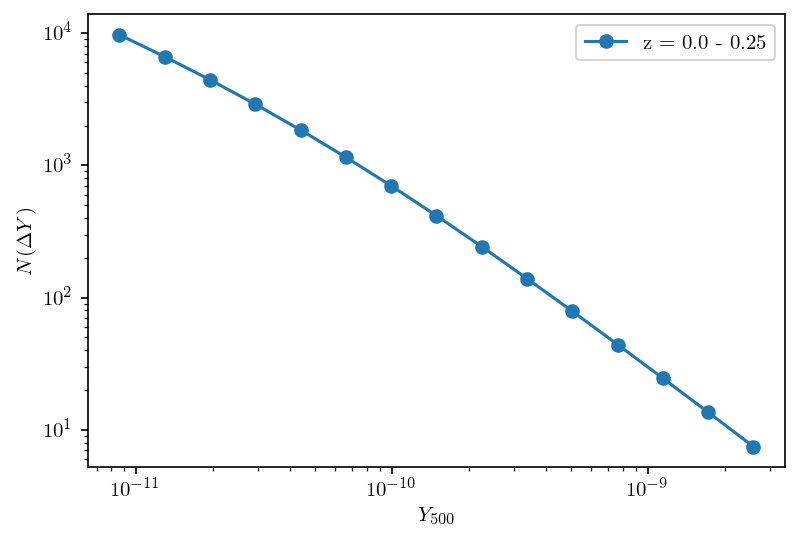

In [20]:
plt.figure()
plt.ylabel(r'$N(\Delta Y)$')
plt.xlabel(r'$Y_{500}$')
plt.xscale('log')
plt.yscale('log')
for i in range(len(z_max)):
    plt.plot(Y_bins_limits[i][:-1], counts, c=color_map(i), marker = 'o', 
             label = 'z = {z_min} - {z_max}'.format(z_min = z_min[i], z_max = z_max[i]))
plt.legend(loc = 'best')

## stuff from simulator.py

In [53]:
# Define a mass definition object
hm_def = ccl.halos.MassDef(500, 'critical')
cosmo_ccl = N_countsSimulator.cosmo(theta_fiducial)
nM = ccl.halos.MassFuncTinker08(cosmo_ccl, mass_def=hm_def)

In [54]:
def halo_mass_function(cosmo_ccl, masses, z):
    scale_fact_a = 1 / (1 + z)
    hm_def = ccl.halos.MassDef(500, 'critical')
    
    mass_funct = ccl.halos.MassFuncTinker08(cosmo_ccl, mass_def=hm_def)
        
    dn_dM = np.array([mass_funct.get_mass_function(cosmo_ccl, masses, a) for a in scale_fact_a])
    return dn_dM

In [55]:
def n_counts_trapz_integral(cosmo_ccl, z_steps, mass_grid, theta):
    H0 = 100 * 0.69
    c = ccl.physical_constants.CLIGHT * 1e-3  # in km/s
        
    scale_fact_a = 1 / (1 + z_steps)
    H_z = H0 * ccl.background.h_over_h0(cosmo_ccl, scale_fact_a)
    factor = 4 * np.pi * (c / H_z) * (ccl.background.comoving_radial_distance(cosmo_ccl, scale_fact_a) ** 2)
        
    dN_dlog10Mdz = halo_mass_function(cosmo_ccl, mass_grid.flatten(), z_steps) 
    dN_dlog10Mdz = dN_dlog10Mdz.T.reshape((mass_grid.shape[0], mass_grid.shape[1], z_steps.shape[0]), order='C')
    N_counts_dz = factor[np.newaxis, np.newaxis, :] * np.trapz(dN_dlog10Mdz, np.log10(mass_grid[:, :, np.newaxis]), axis=1)
        
    integral_trapz = np.trapz(N_counts_dz, z_steps, axis=-1)
    return integral_trapz

In [56]:
def all_n_counts_trapz(z_min, z_max, log10masses, theta, n_steps_z=100, n_steps_masses=1000):
    N_counts_true = np.zeros((log10masses.shape[1], len(z_min)))
        
    log10mass_mins = log10masses[0]
    log10mass_maxs = log10masses[1]
        
    nm_bins = log10mass_maxs.shape[0]
    delta_bin = log10mass_maxs - log10mass_mins
    mass_grid = 10 ** (log10mass_mins[:, np.newaxis] +
                        np.linspace(0, 1, n_steps_masses) * delta_bin[:, np.newaxis])
    print(mass_grid.shape)
    print(mass_grid.flatten().shape)
    
    cosmo_ccl = N_countsSimulator.cosmo(theta)
    t1 = time.process_time()
    for i in range(len(z_min)):
        z_steps = np.linspace(z_min[i], z_max[i], num=n_steps_z)

        N_counts_temp = n_counts_trapz_integral(cosmo_ccl, z_steps, mass_grid, theta)
        N_counts_true[:, i] = N_counts_temp
            
    t2 = time.process_time()
    print(str(t2-t1) + ' s')

    #shape_new = N_counts_true.shape[0] * N_counts_true.shape[1]
    #N_counts_true = N_counts_true.reshape(shape_new)
    return N_counts_true, mass_grid

In [57]:
log10masses = np.linspace(14, 16, num = 5)
z_min = np.linspace(0.1, 0.9, num = 5)
z_max = np.linspace(0.2, 1.0, num = 5)
log10masses_2d = np.stack((log10masses[:-1], log10masses[1:]))

In [58]:
N_counts_true, mass_grid = all_n_counts_trapz(z_min, z_max, log10masses_2d, theta_fiducial)

(4, 1000)
(4000,)
0.6171798470000001 s


In [59]:
N_counts_true

array([[6.93570283e+03, 2.12245611e+04, 2.68131452e+04, 2.27865738e+04,
        1.49412370e+04],
       [5.42447860e+02, 1.28066151e+03, 1.17583495e+03, 6.77034429e+02,
        2.84660843e+02],
       [9.09725925e+00, 1.37157108e+01, 7.16038628e+00, 2.04769383e+00,
        3.83229867e-01],
       [5.72580092e-03, 3.66691546e-03, 6.34184903e-04, 4.53809242e-05,
        1.68220280e-06]])

In [63]:
mass_grid

array([[1.00000000e+14, 1.00115311e+14, 1.00230755e+14, ...,
        3.15499735e+14, 3.15863541e+14, 3.16227766e+14],
       [3.16227766e+14, 3.16592411e+14, 3.16957477e+14, ...,
        9.97697764e+14, 9.98848219e+14, 1.00000000e+15],
       [1.00000000e+15, 1.00115311e+15, 1.00230755e+15, ...,
        3.15499735e+15, 3.15863541e+15, 3.16227766e+15],
       [3.16227766e+15, 3.16592411e+15, 3.16957477e+15, ...,
        9.97697764e+15, 9.98848219e+15, 1.00000000e+16]])

## Step 1

In [114]:
Y_bins_limits = [np.logspace(np.log10(8.6e-12), np.log10(3.9e-9), num = 16)]
n_steps_Y = 100

In [115]:
z_min = np.array([0.])
z_max = np.array([0.25])
n_steps_z = 100
n_bins_z = len(z_min)


n_steps_M_500 = 100
log10_M_500_steps = np.linspace(6, 16, num = n_steps_M_500)
M_500_steps = 10**log10_M_500_steps

In [160]:
def compute_mass_calibration_params_array(theta_mass_calibration, M_500, z):
    t1 = time.process_time()
    alpha_Y = theta_mass_calibration[0]
    beta_Y = theta_mass_calibration[1]
    gamma_Y = theta_mass_calibration[2]
    
    Y_star = theta_mass_calibration[3]
    M_star = theta_mass_calibration[4]
    
    alpha_sigma = theta_mass_calibration[5]
    gamma_sigma = theta_mass_calibration[6]
    sigma_logY0 = theta_mass_calibration[7]
    
    scale_fact_a = 1/(1+z)
    #t2 = time.process_time()
    
    E_z = (ccl.background.h_over_h0(cosmo_ccl, scale_fact_a)**(2/3))
    #if ccl.background.comoving_radial_distance(cosmo_ccl, scale_fact_a) == 0:
     #   D_A_z = np.zeros(len(z))
    #else:
    D_A_z = (ccl.background.comoving_radial_distance(cosmo_ccl, scale_fact_a)/100)**(-2)
   
    mean_Y_500 = Y_star*((M_500/M_star)**alpha_Y)*np.exp(beta_Y*(np.log10(M_500/M_star)**2))*((1+z)**gamma_Y)*E_z*D_A_z
    
    sigma_logY_500 = sigma_logY0*((M_500/M_star)**alpha_sigma)*((1+z)**gamma_sigma)
    
    t2 = time.process_time()
    #print(t2 - t1)
    return mean_Y_500, sigma_logY_500

#### (1)

In [117]:
z_array = np.linspace(z_min, z_max, num = n_steps_z).reshape(1, n_steps_z)
M_array = M_500_steps.reshape(n_steps_M_500, 1)

In [118]:
z_array_flat = np.repeat(z_array, n_steps_M_500, axis=0).flatten()
M_array_flat = np.repeat(M_array, n_steps_z, axis=1).flatten()

In [135]:
a = 1/(1+z_array.flatten())
hmf = [nM.get_mass_function(cosmo_ccl, M_500_steps, a_temp) for a_temp in a]
            

In [119]:
mean_Y_500_flat, sigma_logY_500_flat = compute_mass_calibration_params_array(theta_fiducial_mass_calibration, M_array_flat, z_array_flat)


0.0034815419999993935


/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in power


In [120]:
mean_Y_500 = mean_Y_500_flat.reshape(n_steps_M_500, n_steps_z)
sigma_logY_500 = sigma_logY_500_flat.reshape(n_steps_M_500, n_steps_z)

#### (2)

In [121]:
n_steps_Mz = n_steps_z*n_steps_M_500

In [122]:
Y_bins_temp = np.linspace(Y_bins_limits[0][0], Y_bins_limits[0][1], num = n_steps_Y).reshape(n_steps_Y, 1)
print(Y_bins_temp.shape)
Y_500_array_flat = np.repeat(Y_bins_temp, n_steps_Mz, axis = 1).flatten()
Y_500_array_flat.shape

(100, 1)


(1000000,)

In [123]:
mean_Y_500_flat2 = np.repeat(mean_Y_500_flat.reshape(1, n_steps_Mz), n_steps_Y, axis = 0).flatten()
sigma_logY_500_flat2 = np.repeat(sigma_logY_500_flat.reshape(1, n_steps_Mz), n_steps_Y, axis = 0).flatten()

In [217]:
def compute_probability_Y_500_array(mean_Y_500, sigma_logY_500, Y_500_true): #, M_500, z):
    t1 = time.process_time()
    
    #mean_Y_500, sigma_logY_500 = compute_mass_calibration_params(theta_mass_calibration, M_500, z)
    
    prob_Y_500_true = np.exp(-((np.log10(Y_500_true) - np.log10(mean_Y_500))**2)/(2*(sigma_logY_500**2)))/(np.sqrt(2*np.pi)*sigma_logY_500)/Y_500_true
    
    t2 = time.process_time()
    #print(t2 - t1)
    return prob_Y_500_true

In [180]:
prob_Y_500_array = compute_probability_Y_500_array(mean_Y_500_flat2, sigma_logY_500_flat2, Y_500_array_flat)
prob_Y_500_array = prob_Y_500_array.reshape(n_steps_Y, n_steps_Mz)
prob_Y_500_array.shape

0.06812016999999848


(100, 10000)

In [181]:
integral_trapz1 = np.trapz(prob_Y_500_array, Y_bins_temp, axis = 0)
integral_trapz1 = integral_trapz1.reshape(n_steps_M_500, n_steps_z)

In [182]:
integral_trapz1 = np.array(hmf).T*integral_trapz1
integral_trapz1.shape

(100, 100)

In [183]:
M_500_integral = np.trapz(integral_trapz1, log10_M_500_steps, axis = 0)
M_500_integral.shape

(100,)

In [184]:
H0 = 100 * 0.69
c = ccl.physical_constants.CLIGHT * 1e-3  # in km/s

H_z = H0 * ccl.background.h_over_h0(cosmo_ccl, a)
factor = 4 * np.pi * (c / H_z) * (ccl.background.comoving_radial_distance(cosmo_ccl, a) ** 2)
   
factor.shape

(100,)

In [185]:
np.trapz(M_500_integral*factor, z_array.flatten())

9715.155508234222

#### (3)

In [162]:
def compute_Y500_integral(index, Y_bins_limits, mean_Y_500_flat2, sigma_logY_500_flat2, n_steps_M_500, n_steps_z, n_steps_Y):
    Y_bins_min = Y_bins_limits[index]
    Y_bins_max = Y_bins_limits[index+1]
    Y_bins_temp = np.linspace(Y_bins_min, Y_bins_max, num = n_steps_Y).reshape(n_steps_Y, 1)
    
    Y_500_array_flat = np.repeat(Y_bins_temp, n_steps_Mz, axis = 1).flatten()
    
    prob_Y_500_array = compute_probability_Y_500_array(mean_Y_500_flat2, sigma_logY_500_flat2, Y_500_array_flat).reshape(n_steps_Y, n_steps_Mz)
    
    Y500_integral = np.trapz(prob_Y_500_array, Y_bins_temp, axis = 0).reshape(n_steps_M_500, n_steps_z)
    
    return Y500_integral

In [193]:
Y500_integral = compute_Y500_integral(0, Y_bins_limits[0], mean_Y_500_flat2, sigma_logY_500_flat2, n_steps_M_500, n_steps_z, n_steps_Y)
Y500_integral.shape

0.07139154899999944


(100, 100)

In [194]:
def compute_M500_integral(Y500_integral, hmf, log10_M_500_steps):
    Y500_integral = np.array(hmf).T*Y500_integral
    M_500_integral = np.trapz(Y500_integral, log10_M_500_steps, axis = 0)
    
    return M_500_integral
    

In [195]:
M500_integral = compute_M500_integral(Y500_integral, hmf, log10_M_500_steps)

In [196]:
H0 = 100 * 0.69
c = ccl.physical_constants.CLIGHT * 1e-3  # in km/s

H_z = H0 * ccl.background.h_over_h0(cosmo_ccl, a)
factor = 4 * np.pi * (c / H_z) * (ccl.background.comoving_radial_distance(cosmo_ccl, a) ** 2)
   
def compute_N_integral(M_500_integral, factor, z_array):
    N_counts = np.trapz(M_500_integral*factor, z_array.flatten())
    
    return N_counts

In [197]:
compute_N_integral(M_500_integral, factor, z_array)

9715.155508234222

## Step 2

In [227]:
hm_def = ccl.halos.MassDef(500, 'critical')
cosmo_ccl = N_countsSimulator.cosmo(theta_fiducial)
nM = ccl.halos.MassFuncTinker08(cosmo_ccl, mass_def=hm_def)

In [232]:
#z_min = np.array([0.])
#z_max = np.array([0.25])
z_min = np.array([0., 0.25, 0.5, 0.75, 1.])
z_max = np.array([0.25, 0.5, 0.75, 1., 1.5])
n_steps_z = 100
n_bins_z = len(z_min)


n_steps_M_500 = 100
log10_M_500_steps = np.linspace(6, 16, num = n_steps_M_500)
M_500_steps = 10**log10_M_500_steps

n_steps_Mz = n_steps_z*n_steps_M_500

#Y_bins_limits = [np.logspace(np.log10(8.6e-12), np.log10(3.9e-9), num = 16)]
Y_bins_limits = [np.logspace(np.log10(8.6e-12), np.log10(3.9e-9), num = 16),
                 np.logspace(np.log10(4.3e-12), np.log10(5.1e-10), num = 15),
                 np.logspace(np.log10(3.1e-12), np.log10(1.8e-10), num = 16),
                 np.logspace(np.log10(3.1e-12), np.log10(1.1e-10), num = 14),
                 np.logspace(np.log10(2.5e-12), np.log10(6.6e-11), num = 13)]
n_steps_Y = 1000

In [233]:
M_array = M_500_steps.reshape(n_steps_M_500, 1)
M_array_flat = np.repeat(M_array, n_steps_z, axis=1).flatten()

H0 = 100 * 0.69
c = ccl.physical_constants.CLIGHT * 1e-3  # in km/s

N_counts = []

t1 = time.process_time()

for i in range(n_bins_z):
    z_array = np.linspace(z_min[i], z_max[i], num = n_steps_z).reshape(1, n_steps_z)
    z_array_flat = np.repeat(z_array, n_steps_M_500, axis=0).flatten()
    
    a = 1/(1+z_array.flatten())
    hmf = [nM.get_mass_function(cosmo_ccl, M_500_steps, a_temp) for a_temp in a]
    H_z = H0 * ccl.background.h_over_h0(cosmo_ccl, a)
    factor = 4 * np.pi * (c / H_z) * (ccl.background.comoving_radial_distance(cosmo_ccl, a) ** 2)
    
    mean_Y_500_flat, sigma_logY_500_flat = compute_mass_calibration_params_array(theta_fiducial_mass_calibration, M_array_flat, z_array_flat)
    
    mean_Y_500_flat2 = np.repeat(mean_Y_500_flat.reshape(1, n_steps_Mz), n_steps_Y, axis = 0).flatten()
    sigma_logY_500_flat2 = np.repeat(sigma_logY_500_flat.reshape(1, n_steps_Mz), n_steps_Y, axis = 0).flatten()
    
    indices = np.linspace(0, len(Y_bins_limits[i])-2, num = len(Y_bins_limits[i])-1).astype(int)
    Y500_integral = [compute_Y500_integral(j, Y_bins_limits[i], mean_Y_500_flat2, sigma_logY_500_flat2, n_steps_M_500, n_steps_z, n_steps_Y)
                     for j in indices]
    
    M500_integral = [compute_M500_integral(Y500_integral_temp, hmf, log10_M_500_steps) for Y500_integral_temp in Y500_integral]
    
    N_counts_temp = np.array([compute_N_integral(M_500_integral_temp, factor, z_array) for M_500_integral_temp in M500_integral])
    N_counts.append(N_counts_temp)
    
    print(i)
    
t2 = time.process_time()
print(t2 - t1)

/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in power


0
1
2
3
4
59.98865592199999


In [224]:
len(N_counts)

5

In [236]:
[np.random.poisson(N_counts_temp) for N_counts_temp in N_counts]

[array([9925, 6682, 4415, 2829, 1930, 1202,  701,  397,  240,  141,   88,
          45,   26,   17,    6]),
 array([12049,  7676,  4858,  2938,  1730,   994,   557,   297,   148,
           51,    32,     8,     4,     0]),
 array([5181, 3326, 2181, 1307,  790,  496,  258,  130,   60,   37,   11,
           7,    3,    1,    0]),
 array([1171,  719,  364,  184,   89,   40,   18,    8,    4,    0,    0,
           0,    0]),
 array([413, 200,  95,  40,  23,  10,   2,   0,   0,   0,   0,   0])]

In [234]:
N_counts

[array([9.71507675e+03, 6.63705165e+03, 4.43784687e+03, 2.90020758e+03,
        1.85061420e+03, 1.15259304e+03, 7.00993313e+02, 4.16920354e+02,
        2.43073721e+02, 1.39361773e+02, 7.88474660e+01, 4.41672452e+01,
        2.45604638e+01, 1.35830938e+01, 7.47954642e+00]),
 array([1.18967748e+04, 7.73536905e+03, 4.88165970e+03, 2.98023695e+03,
        1.75364735e+03, 9.90583369e+02, 5.34782217e+02, 2.74595011e+02,
        1.33381913e+02, 6.09208870e+01, 2.59873146e+01, 1.02751946e+01,
        3.73359715e+00, 1.23456863e+00]),
 array([5.28805119e+03, 3.43171841e+03, 2.16849843e+03, 1.33091204e+03,
        7.91357858e+02, 4.54523768e+02, 2.51388095e+02, 1.33447021e+02,
        6.77293358e+01, 3.27365630e+01, 1.50028578e+01, 6.48719102e+00,
        2.63351072e+00, 9.97708694e-01, 3.50633226e-01]),
 array([1.24164205e+03, 7.01418843e+02, 3.81161899e+02, 1.98543563e+02,
        9.87295660e+01, 4.66894801e+01, 2.08942037e+01, 8.80562124e+00,
        3.47638496e+00, 1.27749136e+00, 4.34507806

In [230]:
N_counts

[array([9.71591005e+03, 6.63771574e+03, 4.43837315e+03, 2.90062290e+03,
        1.85094144e+03, 1.15285092e+03, 7.01196947e+02, 4.17081747e+02,
        2.43202194e+02, 1.39464317e+02, 7.89295980e+01, 4.42331838e+01,
        2.46133952e+01, 1.36255785e+01, 7.51361504e+00]),
 array([1.18968539e+04, 7.73540537e+03, 4.88166961e+03, 2.98023236e+03,
        1.75363632e+03, 9.90570895e+02, 5.34771034e+02, 2.74586289e+02,
        1.33375798e+02, 6.09169794e+01, 2.59850299e+01, 1.02739754e+01,
        3.73300665e+00, 1.23431081e+00]),
 array([5.28803139e+03, 3.43169806e+03, 2.16847990e+03, 1.33089641e+03,
        7.91345533e+02, 4.54514598e+02, 2.51381622e+02, 1.33442701e+02,
        6.77266020e+01, 3.27349279e+01, 1.50019375e+01, 6.48670396e+00,
        2.63327007e+00, 9.97598045e-01, 3.50586156e-01]),
 array([1.24162673e+03, 7.01407865e+02, 3.81154434e+02, 1.98538751e+02,
        9.87266264e+01, 4.66877842e+01, 2.08932828e+01, 8.80515206e+00,
        3.47616203e+00, 1.27739300e+00, 4.34467756

In [225]:
N_counts

[array([9.71515551e+03, 6.63710787e+03, 4.43788626e+03, 2.90023461e+03,
        1.85063232e+03, 1.15260489e+03, 7.01000871e+02, 4.16925048e+02,
        2.43076563e+02, 1.39363454e+02, 7.88484399e+01, 4.41678004e+01,
        2.45607765e+01, 1.35832685e+01, 7.47964329e+00]),
 array([1.18968596e+04, 7.73542768e+03, 4.88169927e+03, 2.98026291e+03,
        1.75366385e+03, 9.90593491e+02, 5.34788185e+02, 2.74598377e+02,
        1.33383718e+02, 6.09218025e+01, 2.59877509e+01, 1.02753886e+01,
        3.73367687e+00, 1.23459864e+00]),
 array([5.28808066e+03, 3.43173877e+03, 2.16851216e+03, 1.33092109e+03,
        7.91363649e+02, 4.54527362e+02, 2.51390254e+02, 1.33448269e+02,
        6.77300284e+01, 3.27369306e+01, 1.50030434e+01, 6.48727994e+00,
        2.63355080e+00, 9.97725635e-01, 3.50639895e-01]),
 array([1.24165158e+03, 7.01424667e+02, 3.81165336e+02, 1.98545512e+02,
        9.87306286e+01, 4.66900318e+01, 2.08944762e+01, 8.80574858e+00,
        3.47644079e+00, 1.27751431e+00, 4.34516542

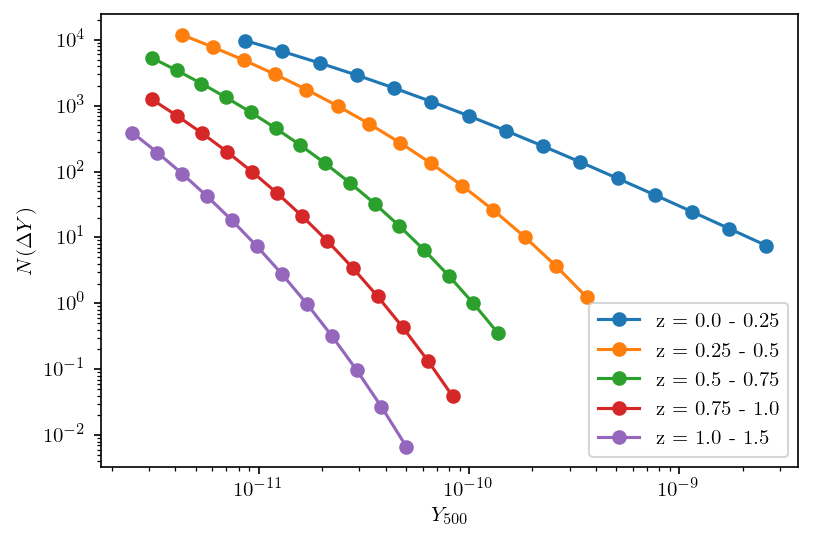

In [231]:
plt.figure()
plt.ylabel(r'$N(\Delta Y)$')
plt.xlabel(r'$Y_{500}$')
plt.xscale('log')
plt.yscale('log')
for i in range(len(z_max)):
    plt.plot(Y_bins_limits[i][:-1], N_counts[i], c=color_map(i), marker = 'o', 
             label = 'z = {z_min} - {z_max}'.format(z_min = z_min[i], z_max = z_max[i]))
plt.legend(loc = 'best')

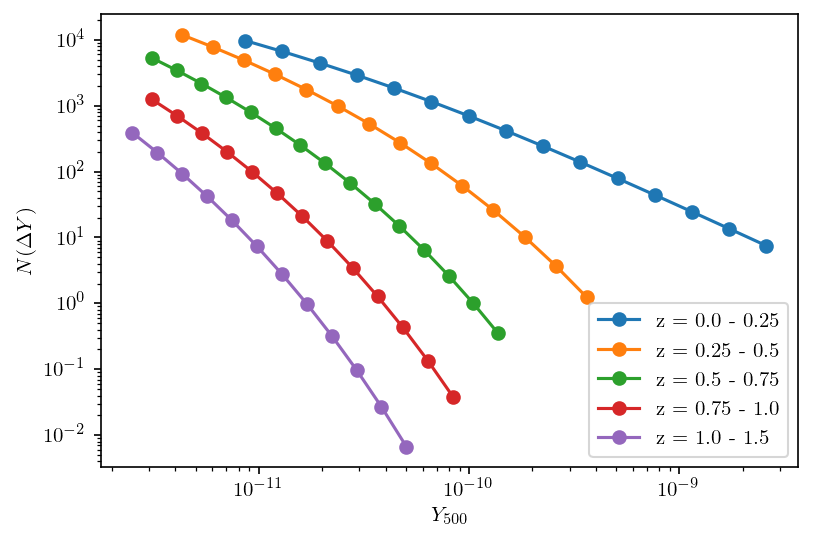

In [226]:
plt.figure()
plt.ylabel(r'$N(\Delta Y)$')
plt.xlabel(r'$Y_{500}$')
plt.xscale('log')
plt.yscale('log')
for i in range(len(z_max)):
    plt.plot(Y_bins_limits[i][:-1], N_counts[i], c=color_map(i), marker = 'o', 
             label = 'z = {z_min} - {z_max}'.format(z_min = z_min[i], z_max = z_max[i]))
plt.legend(loc = 'best')

In [208]:
counts

array([9.71515551e+03, 6.63710787e+03, 4.43788626e+03, 2.90023461e+03,
       1.85063232e+03, 1.15260489e+03, 7.01000871e+02, 4.16925048e+02,
       2.43076563e+02, 1.39363454e+02, 7.88484399e+01, 4.41678004e+01,
       2.45607765e+01, 1.35832685e+01, 7.47964329e+00])